# Campaign for selling personal loans 


This case is about a bank (Thera Bank) which has a growing customer base. Majority of these customers are liability customers (depositors) with varying size of deposits. The number of customers who are also borrowers (asset customers) is quite small, and the bank is interested in expanding this base rapidly to bring in more loan business and in the process, earn more through the interest on loans. In particular, the management wants to explore ways of converting its liability customers to personal loan customers (while retaining them as depositors). A campaign that the bank ran last year for liability customers showed a healthy conversion rate of over 9% success. This has encouraged the retail marketing department to devise campaigns with better target marketing to increase the success ratio with minimal budget.

In this note book, we will build a model that will help the department to identify **the potential customers who have higher probability of purchasing the loan**. This will increase **the success ratio** while at the same time reduce the **cost of the campaign**.

In [39]:
# This is used to plot inline
%matplotlib inline

# Importing all the required modules
import pandas as pd
import numpy as np

# seaborn is a plotting library
import seaborn as sns
import matplotlib.pyplot as plt

# scikit learn for ml algorithms
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# To find the cross validation score
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Using grid search and confusion matrix
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix

In [36]:
import warnings  # Lets ignore the module warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the input file from the hard disk
# It is read as pandas data frame as stored in df variable
df = pd.read_excel("Bank_Personal_Loan_Modelling.xlsx", sheetname="Data")

In [3]:
# Find the shape of input
print("Number of customers data available: {}".format(df.shape[0]))
print("Number of features in the data: {}".format(df.shape[1]))

Number of customers data available: 5000
Number of features in the data: 14


In [4]:
# Check for null values in the data
if not df.isnull().values.any():
    print("No null values in this data")

No null values in this data


### Insights
---
We have data on **5000 customers** and each have **14 features** each.
Fortunately there are no null values in the data.

Description of the data set:

- **ID**: Customer ID
- **Age**: Customer's age in completed years
- **Experience**: Number of years of professional experience
- **Income**: Annual income of the customer (\$000)
- **ZIPCode**: Home Address ZIP code.
- **Family**: Family size of the customer
- **CCAvg**: Average spending on credit cards per month (\$000)
- **Education**: Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional
- **Mortgage**: Value of house mortgage if any. ($000)
- **Personal Loan**: Did this customer accept the personal loan offered in the last campaign?
- **Securities Account**: Does the customer have a securities account with the bank?
- **CD Account**: Does the customer have a certificate of deposit (CD) account with the bank?
- **Online**: Does the customer use internet banking facilities?
- **CreditCard**: Does the customer use a credit card issued by UniversalBank?

We are interested in the Personal Loan feature of this dataset. Lets investigate it further.


In [5]:
# Finding the number of customers who accepted the personal loan that was offered to them in the campaign.
len(df[df["Personal Loan"] == 1])

480

In [6]:
# Current success ratio in percentage
print(str(len(df[df["Personal Loan"] == 1]) / df.shape[0] * 100) + "%")

9.6%


### Insights
---
The number of customers who accepted the personal loan that was offered to them in the campaign is merely **480 customers**. That implies the success ratio is **9.6%**. Our target will be to increase this success ratio.

## Univariate Analysis

In [7]:
# Testing the spread of data
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937913,1.747666,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


### Insights
---
- Age feature is normally distributed with mean = median
- Experience feature has some missing values, because experience cannot be **negative**
- Income is right skewed
- Average Family size of the customer is around 2 people 
- Average credit card spending per month is slightly right skewed
- Morgage distribution seams to have an outlier


In [8]:
# Find number of entries with negative experience
len(df[df.Experience < 0])

52

In [37]:
# Fill the negative experience with mean
df.Experience[df.Experience < 0] = df.Experience.mean()

In [10]:
# Verily that negative values are removed
len(df[df.Experience < 0])

0

## Bivariate Analysis

Constructing Pearsons correlation heatmap using seaborn module.

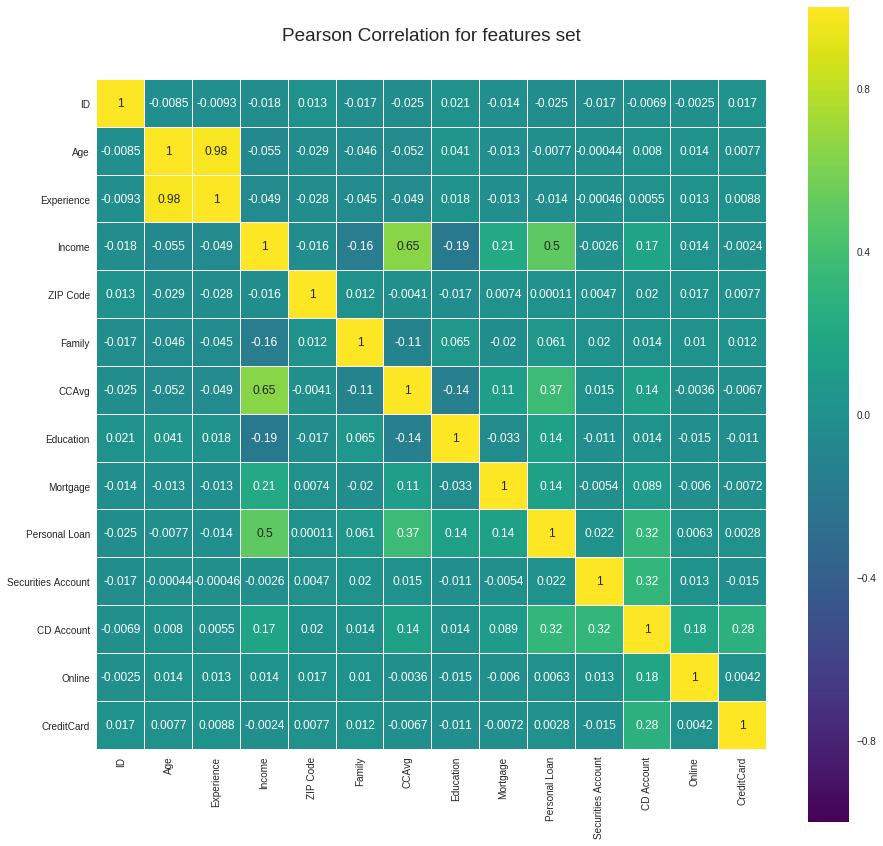

In [11]:
colormap = plt.cm.viridis # Color range to be used in heatmap
plt.figure(figsize=(15,15))
plt.title('Pearson Correlation for features set', y=1.05, size=19)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

### Insights 
---
- There is a **very strong positive correlation** between Age and Experience
- And a **weak positive correlation** between CCAverage and Income

All these analysis tells us that we could potentially keep Age or Experience.

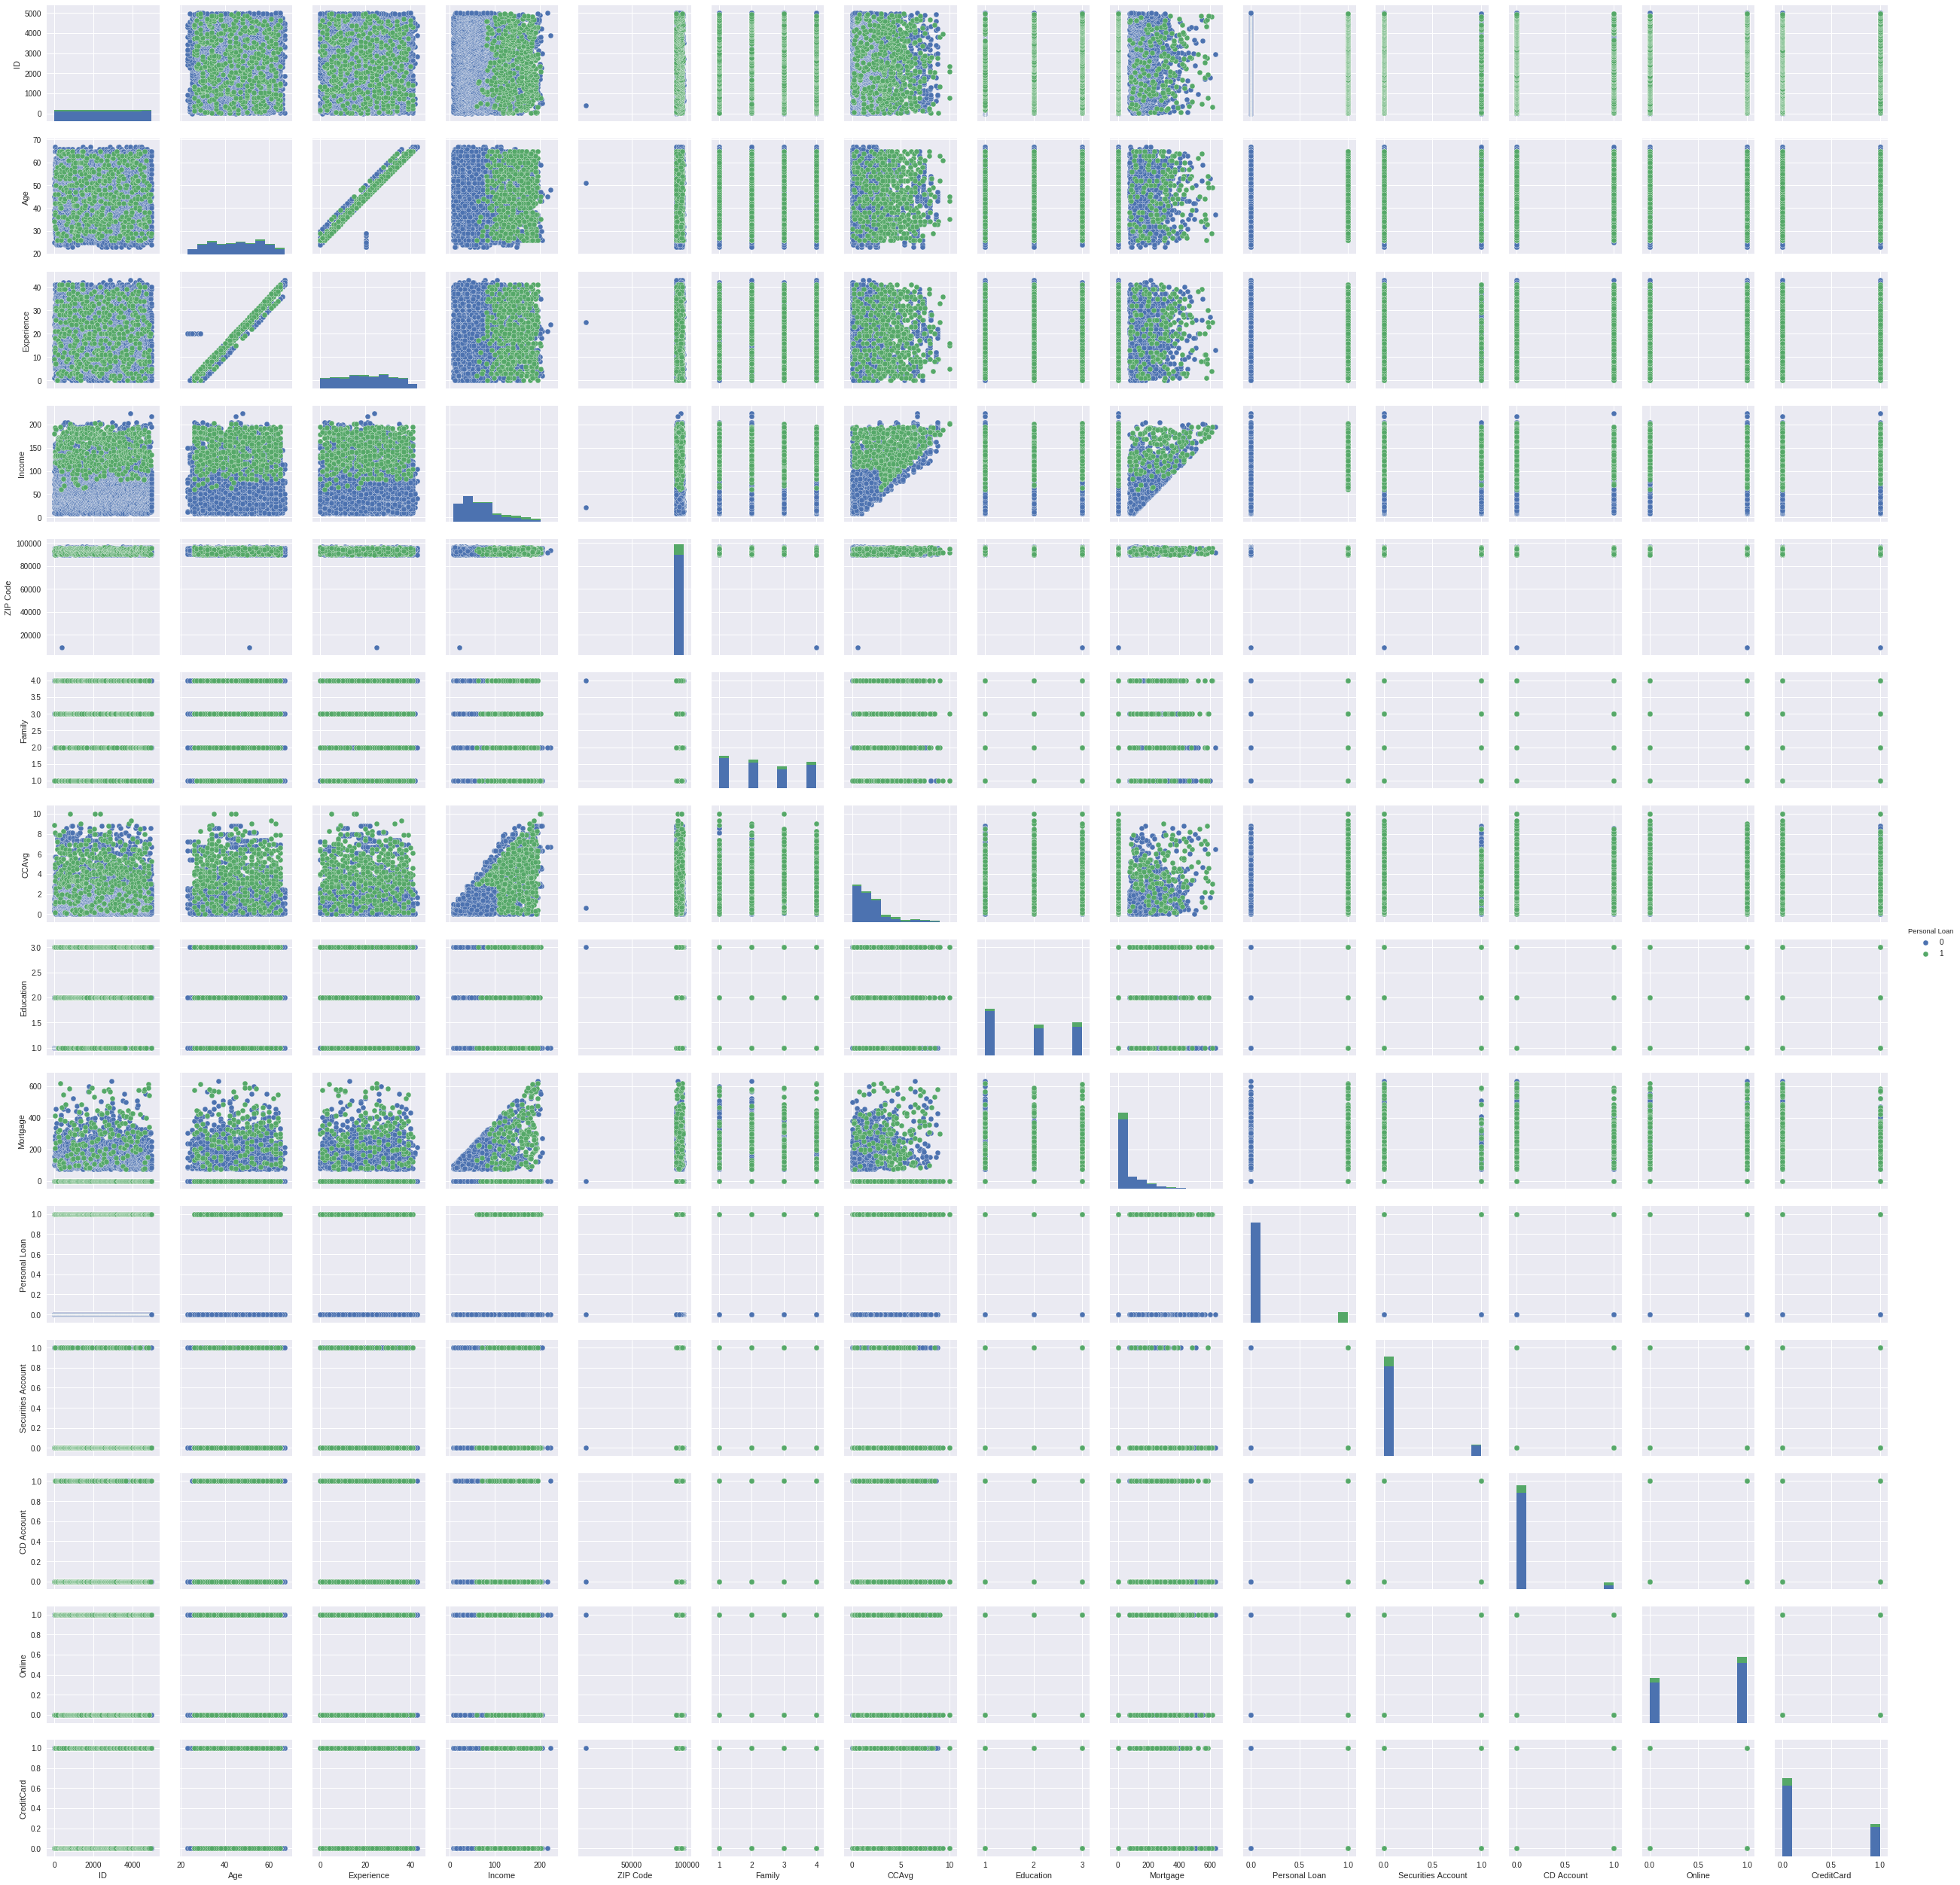

In [12]:
# Draw the pair plot
pairPlot = sns.pairplot(df, hue="Personal Loan")


### Univariate analysis on Personal Loan

([<matplotlib.axis.XTick at 0x7f5fc1f03eb8>,
 <a list of 2 Text xticklabel objects>)

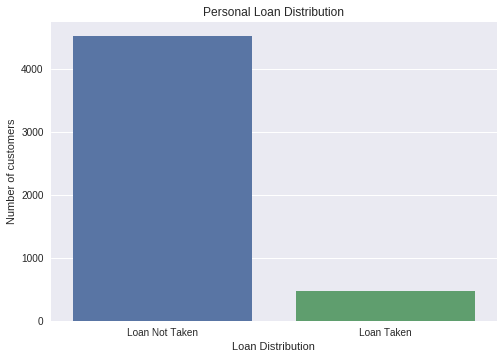

In [13]:
loanNotTaken = len(df[df["Personal Loan"] == 0])
loanTaken = len(df[df["Personal Loan"] == 1])

sns.barplot(x=[0,1], y=[loanNotTaken, loanTaken])
plt.title("Personal Loan Distribution")
plt.xlabel("Loan Distribution")
plt.ylabel("Number of customers")
plt.xticks([0,1], ["Loan Not Taken", "Loan Taken"])

### Insights
---
- The data is strongly biased towards customer that have not take the loan
- Only 9.6% of the customers have taken the loan



### Split dataset

Lets split the data into training and test set using train_test_split function from sklearn. The ratio of the split is 70:30

In [38]:
# Target feature
Y = df[["Personal Loan"]]
le = preprocessing.LabelEncoder()
# Encode the lables for classifier
Y = le.fit_transform(Y)

In [15]:
# Dependent variables
X = df.drop("Personal Loan", axis=1)

In [16]:
test_size = 0.30 # taking 70:30 training and test set
seed = 2  # Random numbmer seeding for reapeatability of the code

xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=test_size, random_state=seed)

## Decision Tree Classifier

In [17]:
seed = 7  # Set the seed for repeatabiliy
# Creating a entropy based decision tree classifier
dtModel = DecisionTreeClassifier(criterion = 'entropy', random_state=seed)


In [18]:
# Fit the model
dtModel.fit(xTrain, yTrain)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=7, splitter='best')

In [19]:
dtModel.score(xTest, yTest)

0.98466666666666669

## K Neighbors Classifier(KNN)

In [20]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(xTrain, yTrain) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [21]:
knn.score(xTest, yTest)

0.89600000000000002

### Using Gridsearch cross validation to find the best regularization parameters

In [22]:
knn = KNeighborsClassifier()

param_grid = { 
    'n_neighbors': list(range(3, 50, 2)),
    'leaf_size': list(range(3, 50, 2))
}

CV_rfc = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, verbose=1)

# Using cross validation
CV_rfc.fit(X, Y)
print(CV_rfc.best_params_)
print(CV_rfc.best_estimator_)
print(CV_rfc.best_score_)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
{'leaf_size': 3, 'n_neighbors': 21}
KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=21, p=2,
           weights='uniform')
0.9042


[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed:   54.4s finished


In [23]:
dtModel = DecisionTreeClassifier(criterion = 'entropy', random_state=seed)

param_grid = { 
    'criterion': ["gini", "entropy"]
}

CV_rfc = GridSearchCV(estimator=dtModel, param_grid=param_grid, cv=5, verbose=1)

# Using cross validation
CV_rfc.fit(X, Y)
print(CV_rfc.best_params_)
print(CV_rfc.best_estimator_)
print(CV_rfc.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'criterion': 'gini'}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=7, splitter='best')
0.9754


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


## Why we chose DT inplace of KNN?
---
- We will use Decision Tree classifier with entropy criterion because is gives much better accuracy over KNN.
- Decision Trees are also very flexible, easy to understand, and easy to debug.
- KNN doesn't know which attributes are more important i.e. when computing distance between data points (usually Euclidean distance or other generalisations of it), each attribute normally weighs the same to the total distance. This means that attributes which are not so important will have the same influence on the distance compared to more important attributes.

Using DT, we got a **accuracy score of 0.9754**

## Ensemble techniques to improve the performance

We have a good accuracy score using DT, but we also have to keep in mind the fact that the data we have is highly biased.
We will try to get better accuracy using some of ensemble techniques.

In [24]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(xTrain, yTrain) 

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=7,
            verbose=0, warm_start=False)

In [25]:
rf.score(xTest, yTest)

0.97599999999999998

### Insights
---
There is slight improvement in accuracy score, but can further improve it by finding the best regularization techniques.


In [26]:
rf = RandomForestClassifier(random_state=seed)

param_grid = { 
    'n_estimators': list(range(10, 30)),
    'max_depth': list(range(3, 30, 2))
}

CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=1)

# Using cross validation
CV_rfc.fit(X, Y)
print(CV_rfc.best_params_)
print(CV_rfc.best_estimator_)
print(CV_rfc.best_score_)

Fitting 5 folds for each of 280 candidates, totalling 1400 fits
{'max_depth': 17, 'n_estimators': 19}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=19, n_jobs=1, oob_score=False, random_state=7,
            verbose=0, warm_start=False)
0.9846


[Parallel(n_jobs=1)]: Done 1400 out of 1400 | elapsed:  1.8min finished


In [27]:
# Using best hyper parameters
rf = RandomForestClassifier(max_depth=17, n_estimators=19, random_state=seed)

yPredicted = rf.fit(xTrain, yTrain).predict(xTest)

In [28]:
# Compute confusion matrix
cnfMatrix = confusion_matrix(yTest, yPredicted)

In [29]:
cnfMatrix

array([[1359,    3],
       [  28,  110]])

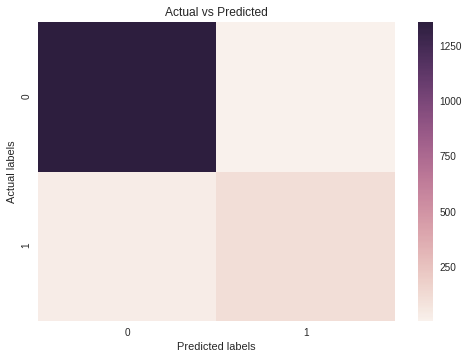

In [30]:
sns.heatmap(cnfMatrix)
plt.title("Actual vs Predicted")
plt.xlabel("Predicted labels")
plt.ylabel("Actual labels")

# Conclusion
---
We got a very good accuracy using the Random Forest Classifier. The main challenge with this data is that the given data is highly biased toward Loan Not Taken. This can be fixed by collecting more samples.

### Future scope

Apply stratified sampling to reduce the bias in the dataset.


In [31]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=0)

for train_index, test_index in sss.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

In [32]:
# Using best hyper parameters
rf = RandomForestClassifier(max_depth=17, n_estimators=19, random_state=seed)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)


0.98533333333333328

### Insights
---
This is a better approach, because we are using Stratified Shuffle Split from sklearn, which samples by preserving the percentage of samples for each class.